In [1]:
!pip install nilearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 14.9 MB/s eta 0:00:00


In [2]:
# Import packages
from nilearn import datasets
import nibabel as nib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nilearn.input_data import NiftiLabelsMasker, NiftiMasker
from nilearn.image import new_img_like
from nilearn.plotting import plot_stat_map
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, r2_score
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

## **Dataset A (Classification)**

In [ ]:
# Reading in dataset A
brain_data = datasets.fetch_oasis_vbm(n_subjects=100)
yeo = datasets.fetch_atlas_yeo_2011()
masker = NiftiLabelsMasker(labels_img=yeo['thick_17'], standardize=True,memory='nilearn_cache')
input_variables = masker.fit_transform(brain_data.gray_matter_maps)
output_variable = np.array(brain_data.ext_vars.mf == 'F', dtype=int) # gives 1 forfemales and 0 for males

### **Question 1**

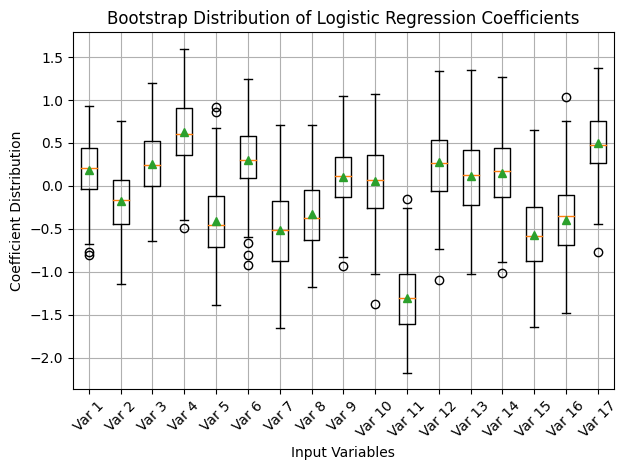

In [ ]:
log_model_q1 = LogisticRegression(C=1.0, random_state=42) # Create logistic model
log_model_q1.fit(input_variables, output_variable) # fit on dataset

n_bootstrap = 200 # Number of bootstrap iterations
coef_samples = [] # Array to store coefficients

for i in range(n_bootstrap):
    # Bootstrap sample the data
    input_resample, output_resample = resample(input_variables, output_variable)
    log_model_q1.fit(input_resample, output_resample) # Train model on resampled data
    coef_samples.append(log_model_q1.coef_[0]) # Store coefficients

coef_samples = np.array(coef_samples) # Convert list of coefficients to numpy array

# Plot distribution of model parameters
plt.boxplot(coef_samples, positions=np.arange(1,18), showmeans=True)
plt.xticks(np.arange(1, 18), [f'Var {i+1}' for i in range(17)], rotation=45)
plt.xlabel('Input Variables')
plt.ylabel('Coefficient Distribution')
plt.title('Bootstrap Distribution of Logistic Regression Coefficients')
plt.grid(True)
plt.tight_layout()
plt.show()

### **Question 2**

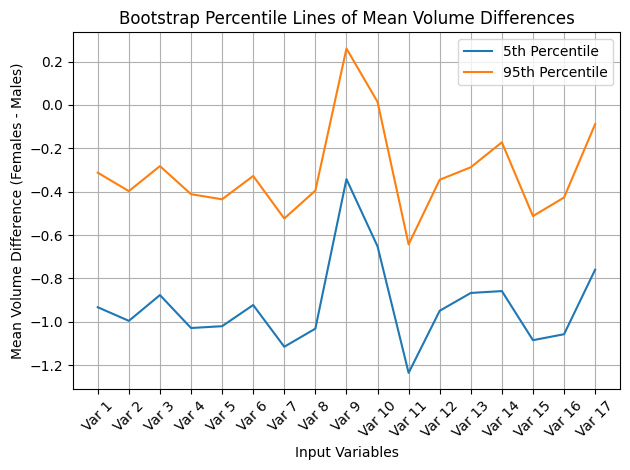

In [ ]:
n_bootstrap = 200 # Number of bootstrap samples

# Store mean differences for each input variable
mean_differences = np.zeros((n_bootstrap, input_variables.shape[1]))

for i in range(n_bootstrap):
    # Resample data
    input_resample, output_resample = resample(input_variables, output_variable)

    # Calculate mean volume for each input variable for males & females
    male_means = np.mean(input_resample[output_resample==0], axis=0)
    female_means = np.mean(input_resample[output_resample==1], axis=0)
    mean_differences[i] = female_means - male_means # Store mean difference

# Calculate 5th & 95th percentiles for each input variable
percentile_5th = np.percentile(mean_differences, 5, axis=0)
percentile_95th = np.percentile(mean_differences, 95, axis=0)

# Plot results
plt.plot(np.arange(1, 18), percentile_5th, label='5th Percentile')
plt.plot(np.arange(1, 18), percentile_95th, label='95th Percentile')
plt.xticks(np.arange(1, 18), [f'Var {i+1}' for i in range(17)], rotation=45)
plt.xlabel('Input Variables')
plt.ylabel('Mean Volume Difference (Females - Males)')
plt.title('Bootstrap Percentile Lines of Mean Volume Differences')
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

### **Question 3**

In [ ]:
# Set training & testing sets
train_inputs = input_variables[:80] # First 80 subjects (input)
train_outputs = output_variable[:80] # First 80 subjects (output)
test_inputs = input_variables[80:] # Last 20 subjects (input)
test_outputs = output_variable[80:] # Last 20 subjects (output)

log_model_q3 = LogisticRegression(C=1.0) # Create Logistic model

n_bootstrap = 200 # Number of iterations
test_predictions = np.zeros((n_bootstrap, len(test_outputs))) # Store predictions

for i in range(n_bootstrap):
    # Resample training data & fit model
    train_inputs_resample, train_outputs_resample = resample(train_inputs, train_outputs)
    log_model_q3.fit(train_inputs_resample, train_outputs_resample) # Train log model
    test_predictions[i] = log_model_q3.predict(test_inputs) # Make predictions on test data

# Use majority vote to get final predicted class for each test subject
final_predictions = np.round(np.mean(test_predictions, axis=0)) # take the average & round
accuracy = accuracy_score(test_outputs, final_predictions)*100 # Calculate accuracy
print(f'Average classification performance on test data: {accuracy:.2f}%')

Average classification performance on test data: 75.00%


### **Question 4**

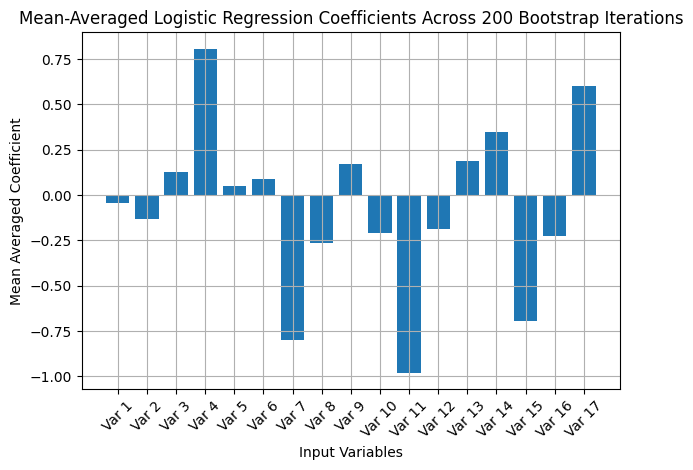

Classification performance on test data using averaged coefficients: 80.00%


In [ ]:
# Set training & testing sets
train_inputs = input_variables[:80] # First 80 subjects (input)
train_outputs = output_variable[:80] # First 80 subjects (output)
test_inputs = input_variables[80:] # Last 20 subjects (input)
test_outputs = output_variable[80:] # Last 20 subjects (output)

log_model_q4 = LogisticRegression(C=1.0) # Create Logistic model

n_bootstrap = 200 # Number of iterations
coef_samples = np.zeros((n_bootstrap, train_inputs.shape[1])) # Store coefficients

for i in range(n_bootstrap):
    # Resample training data & fit on model
    train_inputs_resample, train_outputs_resample = resample(train_inputs, train_outputs)
    log_model_q4.fit(train_inputs_resample, train_outputs_resample)
    coef_samples[i] = log_model_q4.coef_ # Store coefficients

mean_coef = np.mean(coef_samples, axis=0) # Avg coefficients across all samples

# Plot the averaged coefficients as a bar plot
plt.bar(np.arange(1, 18), mean_coef)
plt.xticks(np.arange(1, 18), [f'Var {i+1}' for i in range(17)], rotation=45)
plt.xlabel('Input Variables')
plt.ylabel('Mean Averaged Coefficient')
plt.title('Mean-Averaged Logistic Regression Coefficients Across 200 Bootstrap Iterations')
plt.grid(True)
plt.tight_layout()
plt.show()

log_model_q4.coef_ = np.array([mean_coef]) # Set coeffs of model to the averaged coeffs
predictions = log_model_q4.predict(test_inputs) # Get predictions
accuracy = accuracy_score(test_outputs, predictions) * 100 # Calculate accuracy
print(f'Classification performance on test data using averaged coefficients: {accuracy:.2f}%')

### **Question 5**

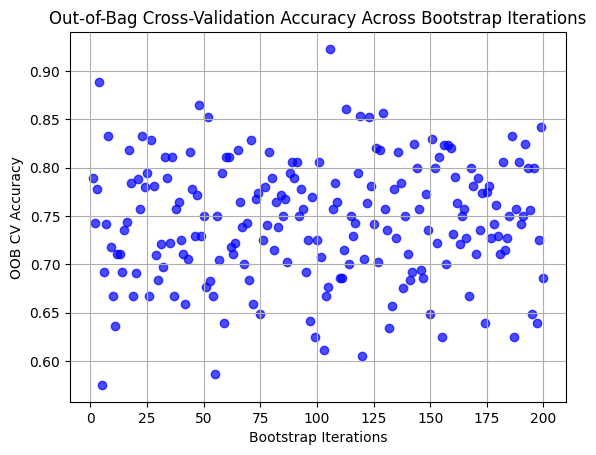

In [ ]:
log_model_q5 = LogisticRegression(C=1.0) # Create Logistic model

n_bootstrap = 200 # Number of bootstrap samples
oob_accuracies = [] # List for storing OOB accuracies

# Perform bootstrap sampling and OOB evaluation
for i in range(n_bootstrap):
    # Resample data
    inputs_resample, outputs_resample = resample(input_variables, output_variable)

    # Identify OOB samples (those not in the bootstrap sample)
    oob_mask = ~np.isin(np.arange(len(output_variable)),
                        np.unique(resample(np.arange(len(output_variable)))))
    oob_inputs = input_variables[oob_mask]
    oob_outputs = output_variable[oob_mask]
    log_model_q5.fit(inputs_resample, outputs_resample) # Train model on sample

    # Evaluate model on the OOB data
    oob_predictions = log_model_q5.predict(oob_inputs) # Get predictions
    oob_accuracy = accuracy_score(oob_outputs, oob_predictions) # Compute accuracy
    oob_accuracies.append(oob_accuracy) # Add accuracy to list

# Plot the scatterplot of OOB accuracies for each bootstrap iteration
plt.scatter(range(1, len(oob_accuracies) + 1), oob_accuracies, color='blue', alpha=0.7)
plt.xlabel('Bootstrap Iterations')
plt.ylabel('OOB CV Accuracy')
plt.title('Out-of-Bag Cross-Validation Accuracy Across Bootstrap Iterations')
plt.grid(True)
plt.show()

## **Dataset B (Regression)**

In [3]:
haxby_dataset = datasets.fetch_haxby(subjects=1)
mask_filename = haxby_dataset.mask
mask_img = nib.load(mask_filename)
process_mask = mask_img.get_fdata() #process_mask = mask_img.get_data()
picked_slice = 29
process_mask[..., (picked_slice + 1):] = 0
process_mask[..., :picked_slice] = 0
process_mask[:, 30:] = 0 # zero out anterior “half” of the brain
process_mask_img = new_img_like(mask_img, process_mask)
nifti_masker = NiftiMasker(smoothing_fwhm=8, mask_img=process_mask_img)
func_filename = haxby_dataset.func[0]
fmri_masked = nifti_masker.fit_transform(func_filename)
labels = pd.read_csv(haxby_dataset.session_target[0], sep=" ")
conditions = labels['labels']
condition_mask = conditions.isin(['face', 'house'])
fmri_masked = fmri_masked[condition_mask]
output_variable = np.array(conditions[condition_mask] == 'face', dtype=int)
print('The only relevant horizontal brain slice has %i voxels.' % process_mask[..., picked_slice].sum())
#plot that slice to get an impression of where the input variables are in the brain
#plot_stat_map(process_mask_img, cut_coords=[-9], display_mode="z", cmap=plt.cm.RdBu_r)


Added README.md to /root/nilearn_data


Dataset created in /root/nilearn_data/haxby2001



 ...done. (0 seconds, 0 min)
 ...done. (0 seconds, 0 min)


Downloaded 301924352 of 314803244 bytes (95.9%,    0.3s remaining) ...done. (8 seconds, 0 min)
Extracting data from /root/nilearn_data/haxby2001/ab078965309539ec0b4c4dfc8b0030ad/subj1-2010.01.14.tar.gz..... done.


The only relevant horizontal brain slice has 739 voxels.


### **Question 6**

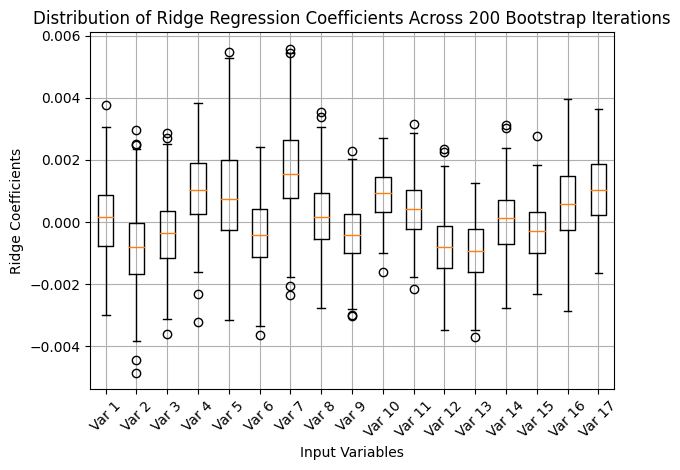

In [4]:
ridge_model_q6 = Ridge() # Create Ridge regression model
ridge_model_q6.fit(fmri_masked, output_variable) # Fit model on data

n_bootstrap = 200 # Number of bootstrap iterations

# Matrix to store coefficients from each bootstrap sample
coef_samples = np.zeros((n_bootstrap, fmri_masked.shape[1]))

for i in range(n_bootstrap):
    # Resample data & fit on Ridge model
    input_resample, output_resample = resample(fmri_masked, output_variable)
    ridge_model_q6.fit(input_resample, output_resample)
    coef_samples[i] = ridge_model_q6.coef_ # Store coefficients

# Plot the distribution of model parameters (only first 17 input variables)
plt.boxplot(coef_samples[:, :17])  # Plot the first 17 input variables
plt.xticks(np.arange(1, 18), [f'Var {i+1}' for i in range(17)], rotation=45)
plt.xlabel('Input Variables')
plt.ylabel('Ridge Coefficients')
plt.title('Distribution of Ridge Regression Coefficients Across 200 Bootstrap Iterations')
plt.grid(True)
plt.tight_layout()
plt.show()

### **Question 7**

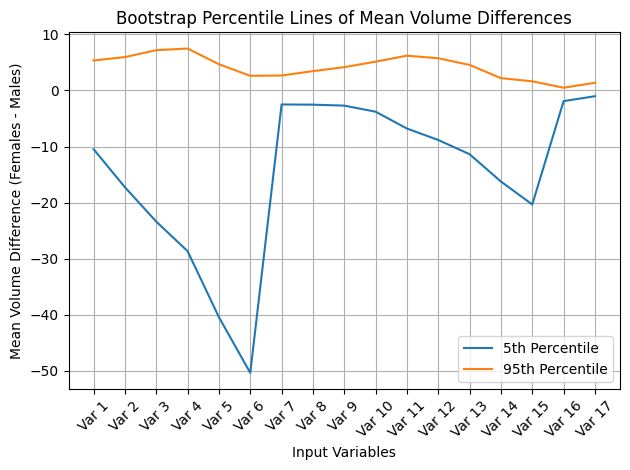

In [5]:
n_bootstrap = 200 # Number of bootstrap samples

# Storing mean differences for each input variable
mean_differences = np.zeros((n_bootstrap, fmri_masked.shape[1]))

for i in range(n_bootstrap):
    # Resample data
    input_resample, output_resample = resample(fmri_masked, output_variable)

    # Calculate mean volume for each input variable for males & females
    male_means = np.mean(input_resample[output_resample==0], axis=0)
    female_means = np.mean(input_resample[output_resample==1], axis=0)
    mean_differences[i] = female_means - male_means # Store mean differences

# Calculate 5th & 95th percentiles for each input variable
percentile_5 = np.percentile(mean_differences, 5, axis=0)
percentile_95 = np.percentile(mean_differences, 95, axis=0)

# Plot results for first 17 input variables
plt.plot(np.arange(1, 18), percentile_5[:17], label='5th Percentile')
plt.plot(np.arange(1, 18), percentile_95[:17], label='95th Percentile')
plt.xticks(np.arange(1, 18), [f'Var {i+1}' for i in range(17)], rotation=45)
plt.xlabel('Input Variables')
plt.ylabel('Mean Volume Difference (Females - Males)')
plt.title('Bootstrap Percentile Lines of Mean Volume Differences')
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

### **Question 8**

In [7]:
# Split the dataset into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(fmri_masked, output_variable,
                                                    train_size=0.8, random_state=42)
n_bootstrap = 200 # Number of bootstrap samples
n_input_variables = X_train.shape[1]
bootstrap_preds = np.zeros((n_bootstrap, len(y_test))) # To store predictions

ridge_model_q8 = Ridge() # Create Ridge regression model

for i in range(n_bootstrap):
    X_resample, y_resample = resample(X_train, y_train) # Resample training data
    ridge_model_q8.fit(X_resample, y_resample) # Fit model on sample
    bootstrap_preds[i] = ridge_model_q8.predict(X_test) # Predict on test data

average_preds = np.mean(bootstrap_preds, axis=0) # Avg predictions across all samples

# Score the final predictions using Ridge regression score method
ridge_score = ridge_model_q8.score(X_test, average_preds)*100
print(f"Ridge regression score on test data & averaged predictions: {ridge_score:.2f}%")

Ridge regression score on test data & averaged predictions: 92.87%


### **Question 9**

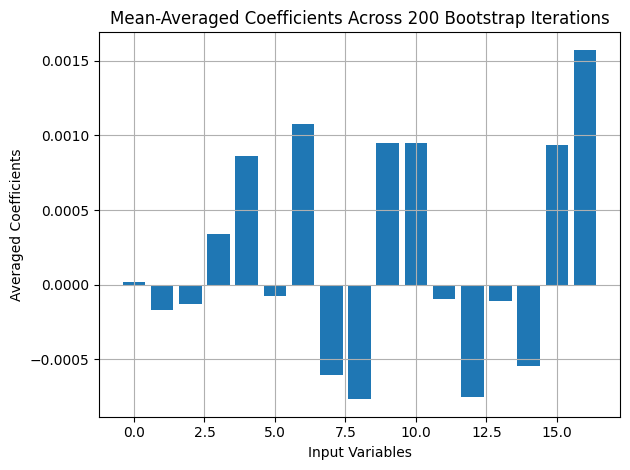

Coefficient of determination (R^2) on test data using averaged coefficients: -10.65


In [16]:
# Split the dataset into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(fmri_masked, output_variable,
                                                    train_size=0.8, random_state=42)
n_bootstrap = 200 # Number of bootstrap samples
coef_storage = np.zeros((n_bootstrap, X_train.shape[1])) # Storing coefficients

ridge_model_q9 = Ridge() # Create Ridge regression model

for i in range(n_bootstrap):
    # Resample training data & fit on model
    X_resample, y_resample = resample(X_train, y_train)
    ridge_model_q9.fit(X_resample, y_resample)
    coef_storage[i] = ridge_model_q9.coef_ # Store coefficients

mean_coef = np.mean(coef_storage, axis=0) # Avg coefficients across all samples

plt.bar(range(17), mean_coef[:17]) # Plot the first 17 averaged coefficients
plt.xlabel('Input Variables')
plt.ylabel('Averaged Coefficients')
plt.title('Mean-Averaged Coefficients Across 200 Bootstrap Iterations')
plt.grid(True)
plt.tight_layout()
plt.show()

ridge_model_q9.coef_ = np.array([mean_coef]) # Set coeffs of model to the averaged coeffs
predictions = ridge_model_q9.predict(X_test) # Get predictions

r_2 = r2_score(y_test, predictions) # Calculate R^2
print(f'Coefficient of determination (R^2) on test data using averaged coefficients: {r_2:.2f}')

### **Question 10**

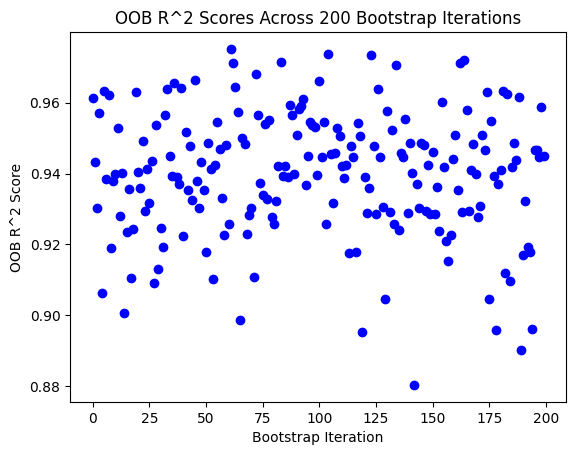

In [17]:
ridge_model_q10 = Ridge() # Create Ridge regression model
n_bootstrap = 200 # Number of bootstrap samples
n_subjects = fmri_masked.shape[0] # Get number of subjects
oob_scores = [] # Storage for OOB R^2 scores

for i in range(n_bootstrap):
    # Resample data
    input_resample, output_resample = resample(fmri_masked, output_variable)

    # Get OOB samples (ones not in bootstrap sample)
    oob_mask = ~np.isin(np.arange(len(output_variable)),
                        np.unique(resample(np.arange(len(output_variable)))))
    oob_inputs = fmri_masked[oob_mask]
    oob_outputs = output_variable[oob_mask]

    ridge_model_q10.fit(input_resample, output_resample) # Train on sample
    oob_predictions = ridge_model_q10.predict(oob_inputs) # Get predictions
    oob_r2_score = r2_score(oob_outputs, oob_predictions) # Compute R^2
    oob_scores.append(oob_r2_score) # Add R^2 to list

# Plot the scatterplot of OOB R^2 scores across the 200 iterations
plt.scatter(range(n_bootstrap), oob_scores, color='blue')
plt.xlabel('Bootstrap Iteration')
plt.ylabel('OOB R^2 Score')
plt.title('OOB R^2 Scores Across 200 Bootstrap Iterations')
plt.show()